In [1]:
from typing import Callable, List, Tuple
import collections
import os
import torch
import catalyst
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead

from catalyst.dl import utils
from torch import nn

from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl import SupervisedRunner

import segmentation_models_pytorch as smp

from pathlib import Path
from models.unets import unet_resnet
from dataflow.dataloaders import get_train_val_loaders
from dataflow.visualisations import tensor_to_rgb
from dataflow.transforms import get_train_augmentation, get_validation_augmentation, prepare_batch_fp32, get_preprocessing
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.



In [2]:
data_dir = Path('/media/wwymak/Storage/spacenet')
summary_data = data_dir / 'summary_ids.csv'
summary_data_df = pd.read_csv(summary_data)


In [3]:
debug=False
batch_size = 8 
val_batch_size = batch_size * 2
num_workers = 12
val_interval = 3
accumulation_steps = 4

train_loader, val_loader, test_loader = get_train_val_loaders(
    summary_data_filepath=summary_data,
    train_transforms= get_train_augmentation(is_display=False, image_size=512),
    val_transforms= get_validation_augmentation(is_display=False, image_size=512),
    batch_size=4,
    num_workers = 8
)

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = val_loader

(4999, 9)
(4249, 9)


In [4]:

# model = smp.Unet(encoder_name="efficientnet-b0", classes=1)
model, preprocessing_fn = unet_resnet("efficientnet-b0")

In [5]:

# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}



learning_rate = 0.001
encoder_learning_rate = 0.0005

# model, preprocessing_function = unet_resnet('efficientnet-b0')
# Since we use a pre-trained encoder, we will reduce the learning rate on it.
layerwise_params = {"encoder*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

# This function removes weight_decay for biases and applies our layerwise_params
model_params = utils.process_model_params(model, layerwise_params=layerwise_params)

# Catalyst has new SOTA optimizers out of box
base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
optimizer = Lookahead(base_optimizer)

# scheduler = optim.lr_scheduler.CyclicLR(optimizer, factor=0.25, patience=2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=[x['lr'] * 10 for x in model_params], steps_per_epoch=len(train_loader), epochs=50)

In [6]:
from datetime import datetime
datetime.now().strftime("%Y-%m-%d-%H")

'2020-08-01-21'

In [7]:


num_epochs = 50
logdir = data_dir /"experiment_tracking"/"unet_resnet"/ datetime.now().strftime("%Y-%m-%d-%H")

device = utils.get_device()
runner = SupervisedRunner(device=device, input_key="image", input_target_key="mask")

In [8]:
%load_ext tensorboard.notebook
%tensorboard --logdir {logdir}

In [ ]:
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback

callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]


runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    # our dataloaders
    loaders=loaders,
    # We can specify the callbacks list for the experiment;
    callbacks=callbacks,
    # path to save logs
    logdir=logdir,
    num_epochs=num_epochs,
    # save our best checkpoint by IoU metric
    main_metric="iou",
    # IoU needs to be maximized.
    minimize_metric=False,
    # prints train logs
    verbose=True,
)

1/50 * Epoch (train):   0% 1/854 [00:00<10:48,  1.31it/s, dice=0.270, iou=0.156, loss=2.280, loss_bce=0.883, loss_dice=0.730, loss_iou=0.844]

/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha)



1/50 * Epoch (train): 100% 854/854 [01:59<00:00,  7.12it/s, dice=0.362, iou=0.221, loss=1.962, loss_bce=0.680, loss_dice=0.638, loss_iou=0.779]
1/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 25.93it/s, dice=0.149, iou=0.081, loss=2.341, loss_bce=0.714, loss_dice=0.851, loss_iou=0.919]
[2020-08-01 21:38:48,615] 
1/50 * Epoch 1 (_base): lr=0.0002 | momentum=0.9500
1/50 * Epoch 1 (train): dice=0.3308 | iou=0.2003 | loss=2.0648 | loss_bce=0.7450 | loss_dice=0.6692 | loss_iou=0.7997
1/50 * Epoch 1 (valid): dice=0.3561 | iou=0.2214 | loss=1.9653 | loss_bce=0.6784 | loss_dice=0.6439 | loss_iou=0.7786


/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:1206: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



2/50 * Epoch (train): 100% 854/854 [01:53<00:00,  7.55it/s, dice=0.399, iou=0.249, loss=1.863, loss_bce=0.639, loss_dice=0.601, loss_iou=0.751]
2/50 * Epoch (valid): 100% 107/107 [00:03<00:00, 27.09it/s, dice=0.151, iou=0.082, loss=2.319, loss_bce=0.690, loss_dice=0.849, loss_iou=0.918]
[2020-08-01 21:40:45,932] 
2/50 * Epoch 2 (_base): lr=0.0002 | momentum=0.9500
2/50 * Epoch 2 (train): dice=0.3543 | iou=0.2172 | loss=1.9617 | loss_bce=0.6665 | loss_dice=0.6457 | loss_iou=0.7828
2/50 * Epoch 2 (valid): dice=0.3605 | iou=0.2248 | loss=1.9366 | loss_bce=0.6522 | loss_dice=0.6395 | loss_iou=0.7752
3/50 * Epoch (train): 100% 854/854 [02:00<00:00,  7.10it/s, dice=0.287, iou=0.168, loss=2.076, loss_bce=0.664, loss_dice=0.713, loss_iou=0.832]
3/50 * Epoch (valid): 100% 107/107 [00:04<00:00, 24.47it/s, dice=0.148, iou=0.080, loss=2.321, loss_bce=0.686, loss_dice=0.852, loss_iou=0.920]
[2020-08-01 21:42:52,773] 
3/50 * Epoch 3 (_base): lr=0.0002 | momentum=0.9500
3/50 * Epoch 3 (train): dice=0

In [24]:
# for now, just test on the validation iamges
import numpy as np
# this get predictions for the whole loader
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=test_loader, resume=f"{logdir}/checkpoints/best.pth")
)))

print(type(predictions))
print(predictions.shape)

<class 'numpy.ndarray'>
(127, 1, 512, 512)


In [48]:
val_images = []
val_masks = []
for batch in val_loader:
    val_images.append(batch['image'])
    val_masks.append(batch['mask'])

In [49]:
val_images = np.vstack(val_images)
val_masks = np.vstack(val_masks)

In [50]:
val_images = np.moveaxis(val_images, 1, -1)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


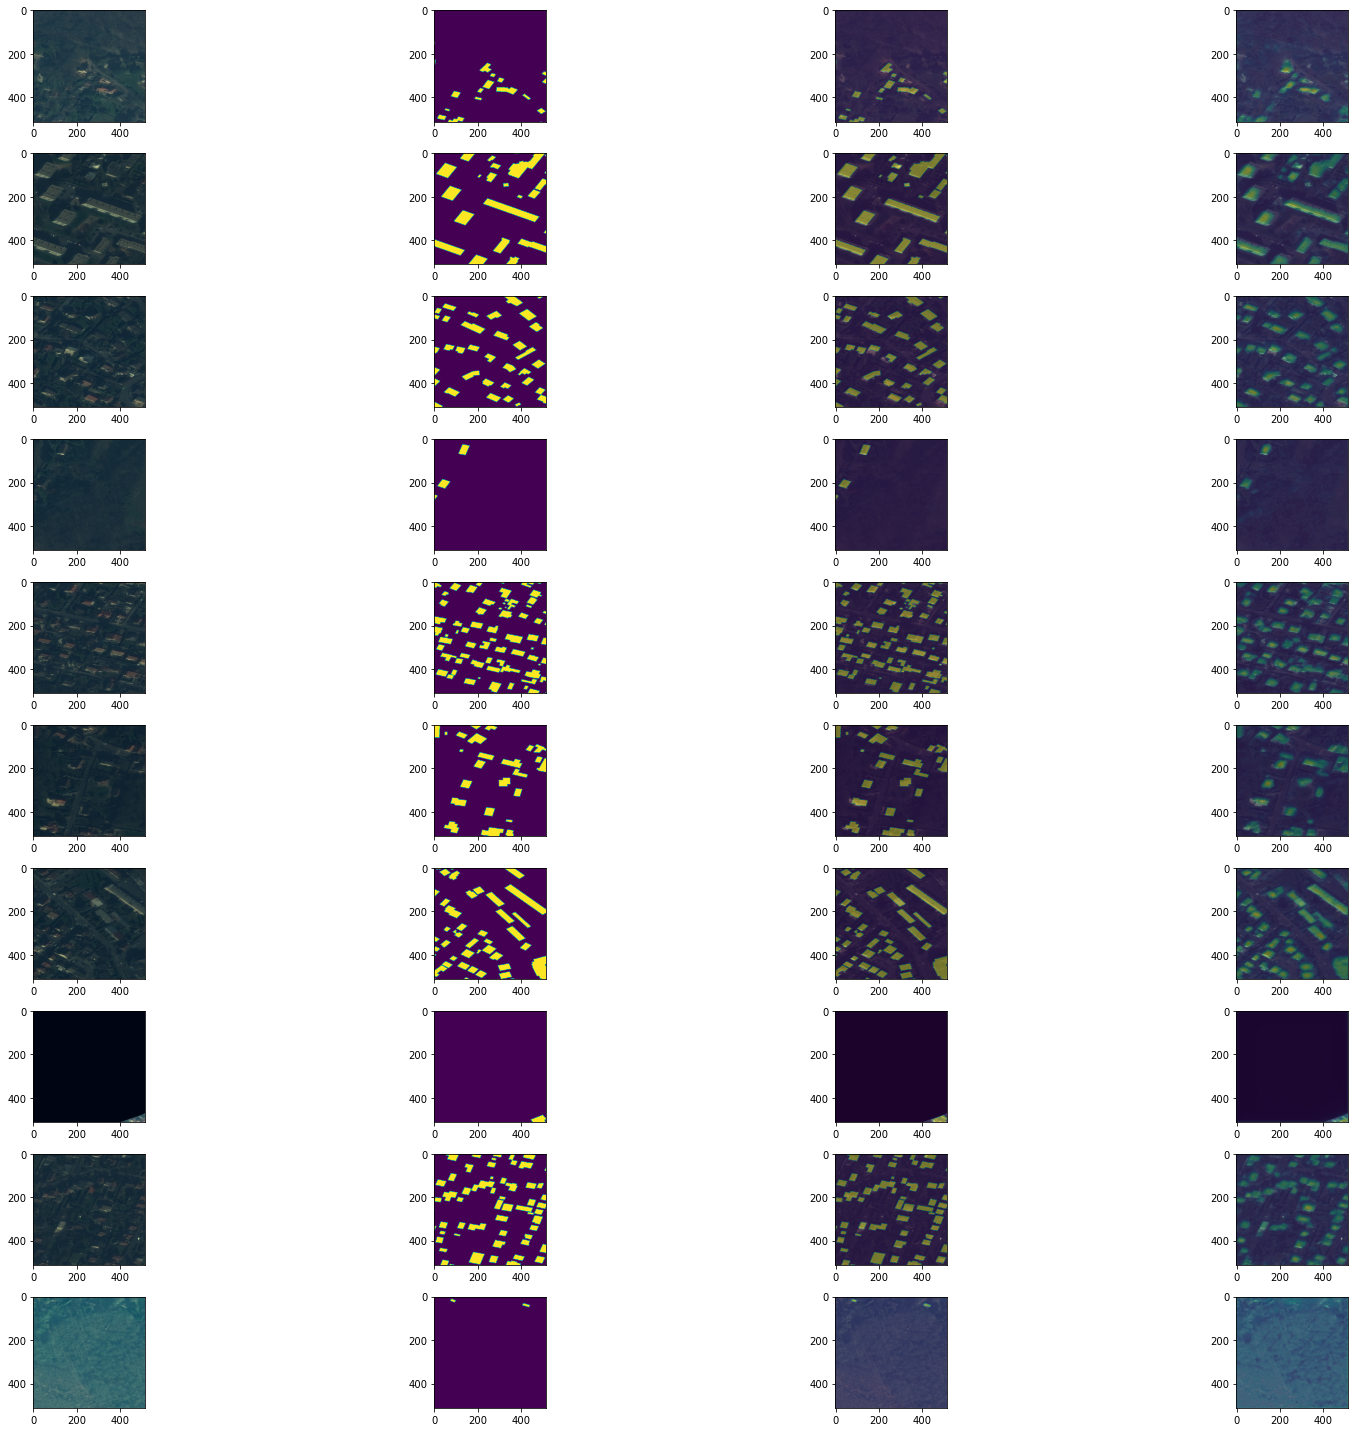

In [56]:
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(5 * 5, 4 * 5))
for i in range(10):
    print(img_normed.min(), img_normed.max())
    img_normed = (val_images[i] - val_images[i].min())/(val_images[i].max() - val_images[i].min())
    axs[i, 0].imshow(img_normed)
    axs[i, 1].imshow(val_masks[i].squeeze())
    axs[i, 2].imshow(img_normed)
    axs[i, 2].imshow(val_masks[i].squeeze(), alpha=0.4)
    axs[i, 3].imshow(img_normed)
    axs[i, 3].imshow(predictions[i].squeeze(), alpha=0.4)
plt.tight_layout()